# Define the system  

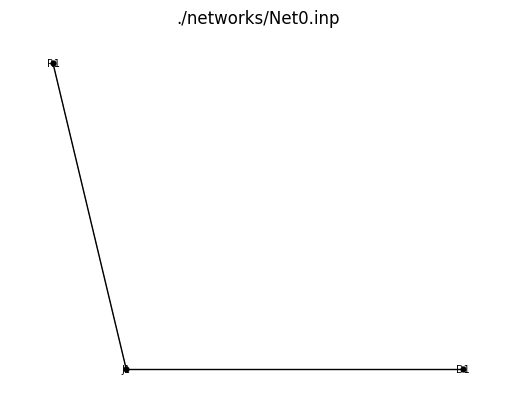

<Axes: title={'center': './networks/Net0.inp'}>

In [106]:
import wntr
import wntr_quantum
import numpy as np
import matplotlib.pyplot as plt
# Create a water network model
inp_file = './networks/Net0_CM.inp'
inp_file = './networks/Net0.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

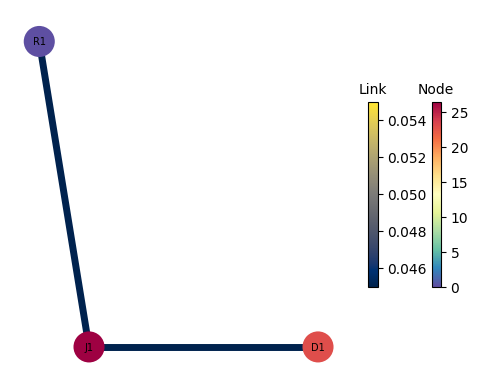

<Axes: >

In [107]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
flow_at_5hr = results.link['flowrate'].loc[0, :]
wntr.graphics.plot_network(wn, link_attribute=flow_at_5hr, 
                           node_attribute=pressure_at_5hr, 
                           node_size=500, 
                           link_width=5, 
                           node_labels=True,
                           link_cmap=plt.cm.cividis)

In [108]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 26.477, 22.954], dtype=float32)

## Run with the QUBO Polynomial Solver

In [109]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [110]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 7
step = (4./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0, var_base_name="x")

nqbit = 7
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 1.574803)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.031496)


Solve the system classically

In [111]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, bin_rep_sol, cvgd = net.classical_solutions()
ref_sol / ref_values

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.   , 0.999, 0.998])

In [112]:
bin_rep_sol

[1,
 1,
 [0, 0, 0, 1, 1, 1, 0],
 [0, 0, 0, 1, 1, 1, 0],
 [1, 1, 1, 0, 1, 1, 0],
 [0, 0, 0, 0, 1, 1, 0]]

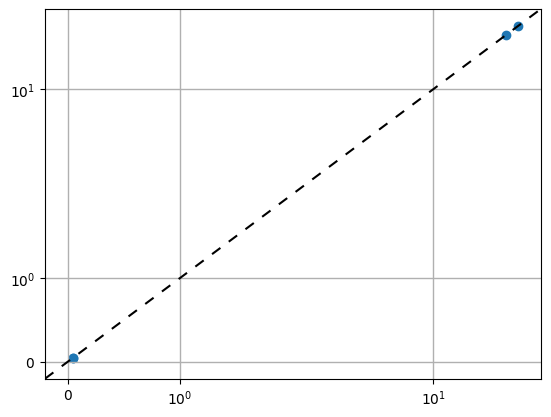

In [113]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values, encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [114]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.matrices = net.initialize_matrices(model)

In [115]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
# from wntr_quantum.sampler.simulated_annealing_parallel import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [116]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse
net.qubo = QUBOPS_MIXED(net.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in net.matrices)
net.qubo.qubo_dict = net.qubo.create_bqm(matrices, strength=0)

In [117]:
from wntr_quantum.sampler.step.full_random import RandomStep
from wntr_quantum.sampler.step.full_random import IncrementalStep
# from wntr_quantum.sampler.step.full_random import ParallelIncrementalStep 

var_names = sorted(net.qubo.qubo_dict.variables)
net.qubo.create_variables_mapping()
# mystep = RandomStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)
mystep = IncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=1)
# mystep = ParallelIncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=100)

# generate init sample

In [118]:
# from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample
# x = generate_random_valid_sample(net.qubo)
# x0 = list(x.values())

In [119]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample
x = modify_solution_sample(net, bin_rep_sol, modify=['flows', 'heads'])
x0 = list(x.values())

In [120]:
eref = net.qubo.energy_binary_rep(bin_rep_sol)

In [121]:
num_sweeps = 2000
Tinit = 1E1
Tfinal = 1E-1
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))
Tschedule = np.append(Tschedule, np.zeros(1000))
# Tschedule = np.zeros(10000)

In [ ]:
mystep.optimize_values = np.arange(2,6)
res = sampler.sample(net.qubo, init_sample=x0, Tschedule=Tschedule, take_step=mystep, save_traj=True, verbose=False)

mystep.optimize_values = np.arange(2,4)
res2 = sampler.sample(net.qubo, init_sample=res.res, Tschedule=Tschedule, take_step=mystep, save_traj=True, verbose=False)

mystep.optimize_values = np.arange(4,6)
res3 = sampler.sample(net.qubo, init_sample=res.res2, Tschedule=Tschedule, take_step=mystep, save_traj=True, verbose=False)

mystep.verify_quadratic_constraints(res.res)

100%|██████████| 4000/4000 [00:05<00:00, 775.12it/s]


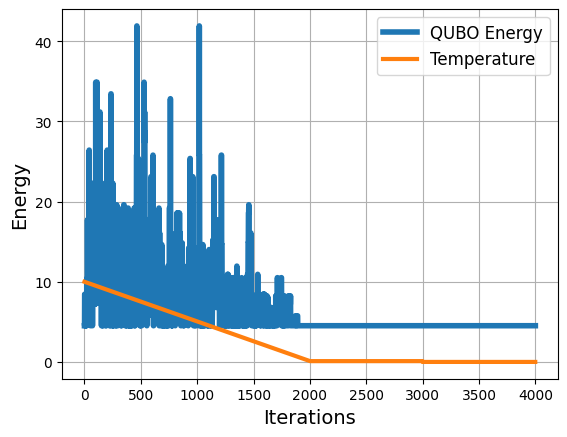

In [ ]:
import matplotlib.pyplot as plt
eplt = res3.energies-eref[0]

# fig, ax1 = plt.subplots()

left, bottom, width, height = [0.55, 0.55, 0.3, 0.3]

plt.plot(res.energies[:]-eref, lw=4, label="QUBO Energy")
plt.plot(Tschedule, lw=3, label='Temperature')
# ax1.axline((0, 0), slope=0, color="black", lw=4, linestyle=(4, (1, 2)))
plt.grid(which='both')
# plt.yscale('symlog')

plt.ylabel('Energy', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.legend(fontsize=12)

# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(eplt[-1000:])
# ax2.grid()
# ax2.axline((0, 0), slope=0, color="orange", linestyle=(1, (1, 2)))
# ax2.set_yscale('symlog')




In [124]:
idx_min = np.array([e for e in res.energies]).argmin()
# idx_min = -1
sol = res.trajectory[idx_min]
sol = net.qubo.decode_solution(np.array(sol))
sol = net.combine_flow_values(sol)
sol = net.convert_solution_to_si(sol)

In [125]:
print(eref[0], res.energies[idx_min])
print(eref[0] - res.energies[idx_min])

-9562.760602598233 [-9558.244]
[-4.517]


Text(0.5, 1.0, 'Pressure')

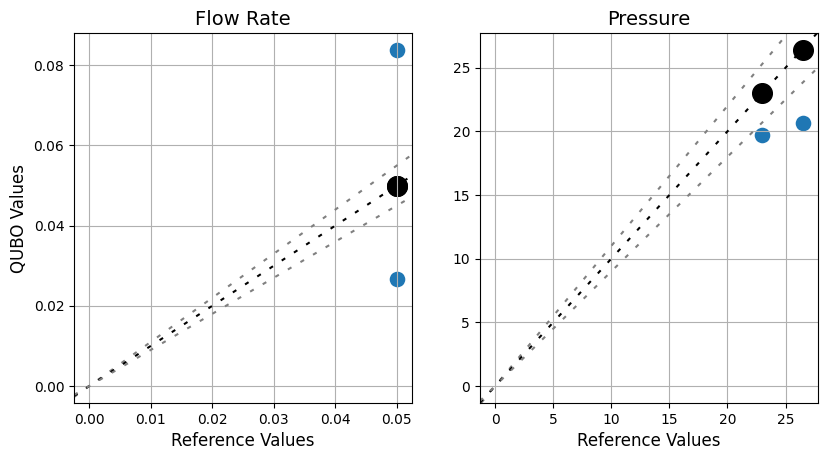

In [126]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

ax1.scatter(ref_values[:2], encoded_ref_sol[:2], c='black', s=200, label='Best solution')
ax1.scatter(ref_values[:2], sol[:2], s=150, lw=1, edgecolors='w', label='Sampled solution')


ax1.set_xlabel('Reference Values', fontsize=12)
ax1.set_ylabel('QUBO Values', fontsize=12)
ax1.set_title('Flow Rate', fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


ax2.scatter(ref_values[2:], encoded_ref_sol[2:], c='black', s=200, label='Best solution')
ax2.scatter(ref_values[2:], sol[2:], s=150, lw=1, edgecolors='w', label='Sampled solution')
ax2.grid()


ax2.set_xlabel('Reference Values', fontsize=12)
ax2.set_title('Pressure', fontsize=14)

In [127]:
def flatten_list(lst):
    out = []
    for elmt in lst:
        if not isinstance(elmt, list):
            out += [elmt]
        else:
            out += elmt
    return out

bin_rep_flat = flatten_list(bin_rep_sol)
xt_bin_rep_flat = net.qubo.extend_binary_representation(bin_rep_flat)
# xt_bin_rep_flat.values()

In [128]:
print(np.array(res.trajectory[idx_min])[net.qubo.index_variables])
print(np.array(bin_rep_flat))

[1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0]
[1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0]


In [129]:
xx = np.array(res.trajectory[idx_min])[net.qubo.index_variables]
net.qubo.energy_binary_rep(xx)

array([-9558.244])

In [130]:
r = np.array(res.trajectory[idx_min])[net.qubo.index_variables]

In [131]:
def un_flatten_list(lst):
    out = []
    count = 0
    for er in net.qubo.mixed_solution_vectors.encoded_reals:
        nqbit = er.nqbit
        d = (np.array(lst)[count:count+nqbit]).tolist()
        out.append(d)
        count += nqbit
    return out
unflat_r = un_flatten_list(r)

  0%|          | 0/64 [00:00<?, ?it/s]

/tmp/ipykernel_5469/1665958244.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
100%|██████████| 64/64 [00:03<00:00, 19.03it/s]


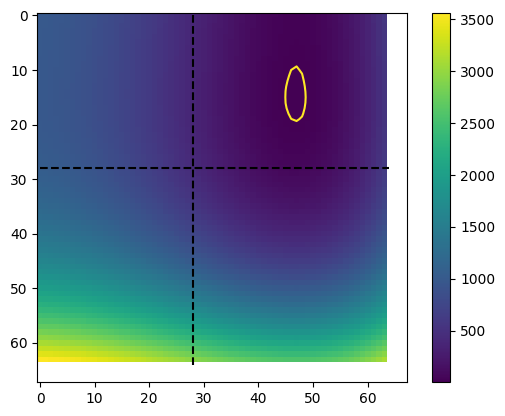

In [132]:
import itertools
from tqdm import tqdm
from copy import deepcopy


nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit

i2 = 0
random1 = np.random.randint(2,size=nqbit).tolist()
random2 = np.random.randint(2,size=nqbit).tolist()

max_size = 64
iter_data = np.array(list(itertools.product([0, 1], repeat=nqbit)))
scale_factor = int(len(iter_data)/max_size)
if len(iter_data>max_size):
    iter_data = iter_data[::scale_factor,:]

energies = np.zeros((max_size,max_size))

for data2 in tqdm(iter_data):
    i3 = 0
    for data3 in iter_data:
        # print(list(data))
        mod_bin_rep_sol = deepcopy(bin_rep_sol)
        mod_bin_rep_sol[2] = list(data2)[::-1]
        mod_bin_rep_sol[3] = list(data3)[::-1]
        # mod_bin_rep_sol[4] = random1
        # mod_bin_rep_sol[5] = random2
        mod_bin_rep_sol[4] = unflat_r[4]
        mod_bin_rep_sol[5] = unflat_r[5]
        # mod_bin_rep_sol[4] = np.ones(5).tolist()
        # mod_bin_rep_sol[5] = np.ones(5).tolist()

        # x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
        # x0 = list(x.values())
        energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
        i3+=1
    i2+=1

# x, y = np.arange(2**nqbit), np.arange(2**nqbit)
# x,y = np.meshgrid(x,y)
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot_surface(x,y,energies)

plt.imshow(energies- eref)
plt.colorbar()
x2 = int(''.join(str(i) for i in bin_rep_sol[2][::-1]),base=2)/scale_factor
x3 = int(''.join(str(i) for i in bin_rep_sol[3][::-1]),base=2)/scale_factor
plt.contour(energies-eref, levels=[1e-2,1,2, 10])
plt.hlines(x3,0,max_size,ls='--',colors='black')
plt.vlines(x2,0,max_size,ls='--',colors='black')

  0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_5469/3475343188.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
/tmp/ipykernel_5469/3475343188.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies2[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
100%|██████████| 128/128 [00:00<00:00, 680.44it/s]


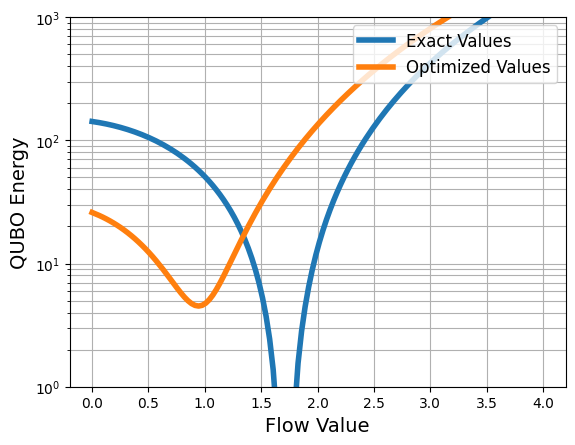

In [133]:
import itertools
from tqdm import tqdm

nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit

random1 = np.random.randint(2,size=nqbit).tolist()
random2 = np.random.randint(2,size=nqbit).tolist()

i2 = 0

iter_data = np.array(list(itertools.product([0, 1], repeat=nqbit)))
if len(iter_data>128):
    iter_data = iter_data[::int(len(iter_data)/128),:]

energies = np.zeros(128)
energies2 = np.zeros(128)

for data2 in tqdm(iter_data):

    mod_bin_rep_sol = deepcopy(bin_rep_sol)
    mod_bin_rep_sol[3] = list(data2)[::-1]
    # mod_bin_rep_sol[2] = list(data2)[::-1]
    energies[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)

    # mod_bin_rep_sol[3] = random1 # unflat_r[3]
    mod_bin_rep_sol[2] = unflat_r[2]
    mod_bin_rep_sol[4] = unflat_r[4]
    mod_bin_rep_sol[5] = unflat_r[5]
    energies2[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
    i2+=1


encoded_real = net.qubo.mixed_solution_vectors.encoded_reals[2]
xaxis_val = []
for i in range(len(iter_data)):
    ibin = np.binary_repr(i,width=nqbit)
    xaxis_val.append(encoded_real.decode_polynom([int(i) for i in ibin[::-1]]))


plt.semilogy(xaxis_val, energies-eref, lw=4, label='Exact Values')
plt.semilogy(xaxis_val, energies2-eref, lw=4, label='Optimized Values')
plt.xlabel('Flow Value', fontsize=14)
plt.ylabel('QUBO Energy', fontsize=14)
plt.ylim([1E0,1E3])
plt.grid(which='both', axis='both')
plt.legend(loc=1, fontsize=12)

In [134]:
r0 = net.qubo.mixed_solution_vectors.encoded_reals[2]
zz = np.binary_repr(12,width=9)
r0.decode_polynom([int(z) for z in zz[::-1]])

0.3779527559055118

# Embed the problem

In [135]:
import dwave_networkx as dnx
from minorminer import find_embedding
from dwave.embedding import embed_qubo, majority_vote, chain_break_frequency

In [136]:
net.qubo.qubo_dict.to_qubo()[0]

{('x_002_001', 'x_004_004'): -1.7796367476667259,
 ('x_004_004*x_002_001', 'x_004_004'): 0.0,
 ('x_004_004*x_002_001', 'x_002_001'): 0.0,
 ('x_004_005', 'x_004_004'): 5.249325847862305,
 ('x_004_005', 'x_002_001'): -3.5592734953334517,
 ('x_004_005', 'x_004_004*x_002_001'): 1.7763568394002505e-15,
 ('x_004_005*x_002_001', 'x_002_001'): 0.0,
 ('x_004_005*x_002_001', 'x_004_005'): 0.0,
 ('x_003_005', 'x_004_004'): -0.2539525079050158,
 ('x_003_005', 'x_004_004*x_002_001'): 0.5079050158100316,
 ('x_003_005', 'x_004_005'): -0.5079050158100316,
 ('x_003_005', 'x_004_005*x_002_001'): 1.0158100316200631,
 ('x_001_001', 'x_003_005'): -613.0859149345342,
 ('x_003_005*x_001_001', 'x_004_004'): 0.5079050158100316,
 ('x_003_005*x_001_001', 'x_004_004*x_002_001'): -1.0158100316200631,
 ('x_003_005*x_001_001', 'x_004_005'): 1.0158100316200631,
 ('x_003_005*x_001_001', 'x_004_005*x_002_001'): -2.0316200632401262,
 ('x_003_005*x_001_001', 'x_003_005'): 0.0,
 ('x_003_005*x_001_001', 'x_001_001'): 0.0,


In [137]:
# target_graph = dnx.pegasus_graph(6)
# embedding = find_embedding(net.qubo.qubo_dict.to_qubo()[0], target_graph)

In [138]:
# embedding

In [139]:
# dnx.draw_pegasus(dnx.pegasus_graph(6),  node_size=2, width=0.1)

In [140]:
# dnx.draw_pegasus_embedding(target_graph, embedding, node_size=10, width=0.25)